In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from loss import custom_loss_wrapper
import os
import h5py
import glob
from utils import convertXY2PtPhi

2025-07-18 16:41:49.462390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_dir = (
    "/home/users/dprimosc/L1METML/experiments/l1metml_v1/25May21_normf100_clip_140X/"
)
model_name = "25May21_normf100_clip_140Xmodel.h5"
model = load_model(
    model_dir + model_name, custom_objects={"custom_loss": custom_loss_wrapper}
)

In [3]:
# Pre-processing done in .h5 conversion
sample = "VBFHToInvisible"
tag = "25Jul8_140X_v0"
data_dir = (
    f"/ceph/cms/store/user/dprimosc/l1deepmet_data/{tag}/{sample}_PU200/FP/140Xv0/"
)
h5_files = glob.glob(os.path.join(data_dir, f"*.h5"))

In [4]:
# Load and concatenate data from all files
X_data_list = []
Y_data_list = []

for h5_file in h5_files:
    print(f"Loading {os.path.basename(h5_file)}...")
    with h5py.File(h5_file, "r") as f:
        # Check what datasets are available
        if len(X_data_list) == 0:  # Only print once
            print("Datasets in file:", list(f.keys()))

        # Load X and Y data
        X_batch = f["X"][:]  # Shape: (n_events, n_particles, n_features)
        Y_batch = f["Y"][:]  # Shape: (n_events, 2)

        X_data_list.append(X_batch)
        Y_data_list.append(Y_batch)
        print(f"  Loaded {X_batch.shape[0]} events")

# Concatenate all data
data = np.concatenate(
    X_data_list, axis=0
)  # Shape: (total_events, n_particles, n_features)
Y = np.concatenate(Y_data_list, axis=0)  # Shape: (total_events, 2)

print(f"\nTotal concatenated data shape: {data.shape}")
print(f"Total target shape: {Y.shape}")
print(f"Total events: {data.shape[0]}")

Loading perfNano_12509503_3.h5...
Datasets in file: ['X', 'Y']
  Loaded 11999 events
Loading perfNano_12509503_4.h5...
  Loaded 3999 events
Loading perfNano_12509503_0.h5...
  Loaded 7999 events
Loading perfNano_12509503_1.h5...
  Loaded 11999 events
Loading perfNano_12509503_2.h5...
  Loaded 11999 events

Total concatenated data shape: (47995, 128, 10)
Total target shape: (47995, 2)
Total events: 47995


In [19]:
# Assuming 'data' is loaded and has shape (batch_size, 128, >=8)
# Reconstruct X0-X3 from the 'data' array according to the encoding

# X0: pt, eta, phi, puppi_w
X0 = data[:, :, [0, 3, 4, 5]]

# X1: pt*cos(phi), pt*sin(phi)
X1 = data[:, :, [1, 2]]

# X2: encoded pdgId
X2 = data[:, :, 6].astype(int)

# X3: encoded charge
X3 = data[:, :, 7].astype(int)

In [20]:
# Ensure X2 and X3 indices are within the valid range for the embedding layer
# X2_clipped = np.clip(X2, 0, 3)
# X3_clipped = np.clip(X3, 0, 3)

# Run inference
predictions = model.predict([X0, X1, X2, X3])

1500/1500 [==============================] - 4s 2ms/step


In [21]:
# print(predictions)
# print(Y)

In [22]:
# Calculate the magnitude (Euclidean norm) of each prediction vector
prediction_magnitudes = np.linalg.norm(predictions, axis=1)
print(prediction_magnitudes)
target_magnitudes = np.linalg.norm(Y, axis=1)

[ 18.69594   43.616302 178.17862  ...  30.335585  17.1601   115.7096  ]


In [23]:
# Tarray_PU = np.load(os.path.join(model_dir, "25May21_normf100_clip_140XTTbar_feature_array_PUMET.npy"))
# Tarray_PU_target = np.load(os.path.join(model_dir, "25May21_normf100_clip_140XTTbar_target_array_PUMET.npy"))

In [31]:
predictions.shape 

(47995, 2)

In [ ]:
# Save predictions as the feature array
np.save(
    os.path.join(model_dir, f"{sample}_feature_array_MLMET.npy"), predictions
)

# Save the target array Y
np.save(os.path.join(model_dir, f"{sample}_target_array_MLMET.npy"), Y)

In [ ]:
# TODO: check for correctness
# Compute PUPPI MET prediction using input features
# px = pt * cos(phi), py = pt * sin(phi), puppiw = X1[..., 1]
# X0[..., 1] = pt*cos(phi), X0[..., 2] = pt*sin(phi), X1[..., 1] = puppiw

# Sum over all particles for each event: MET_px = -sum(puppiw * px), MET_py = -sum(puppiw * py)
puppi_px = X1[..., 0] * X0[..., 3]
puppi_py = X1[..., 1] * X0[..., 3]
puppi_met_components = np.stack(
    [-np.sum(puppi_px, axis=1), -np.sum(puppi_py, axis=1)], axis=1
)

# Calculate MET magnitude from px, py components
puppi_met_magnitude = np.linalg.norm(puppi_met_components, axis=1)  # Shape: (n_events,)

# Calculate target MET magnitude
target_met_magnitude = np.linalg.norm(Y, axis=1)  # Shape: (n_events,)

# Save PUPPI MET predictions as the feature array
np.save(
    os.path.join(model_dir, f"{sample}_feature_array_PUMET.npy"), puppi_met_components
)

# Save the target array for PUPPI MET
np.save(
    os.path.join(model_dir, f"{sample}_target_array_PUMET.npy"), Y
)

In [27]:
# Count number of events in TTbar and SingleNeutrino datasets
# ttbar_events = Tarray_PU.shape[0]
# singleneutrino_events = predictions.shape[0]

# print(f"Number of TTbar events: {ttbar_events}")
# print(f"Number of SingleNeutrino events: {singleneutrino_events}")

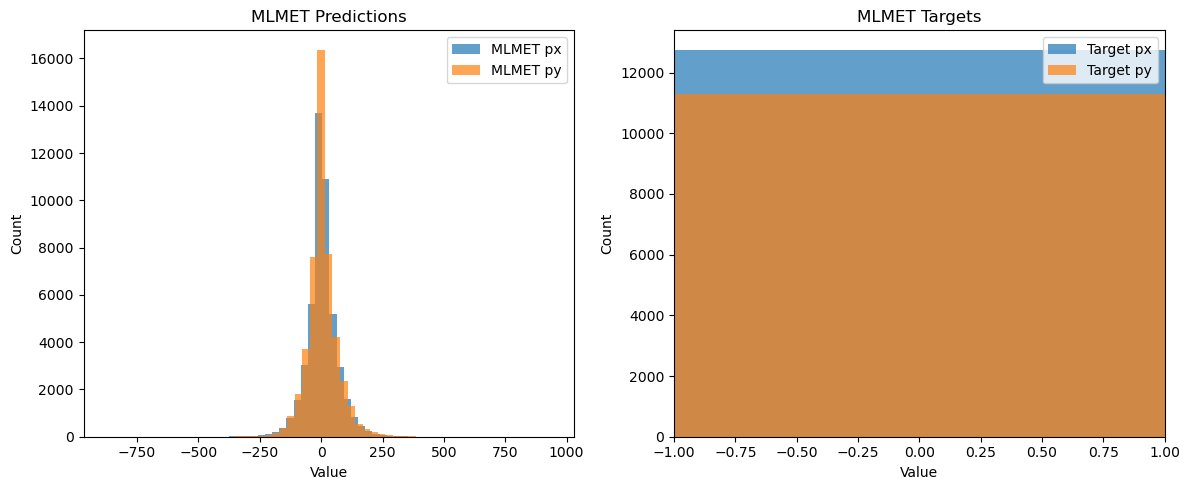

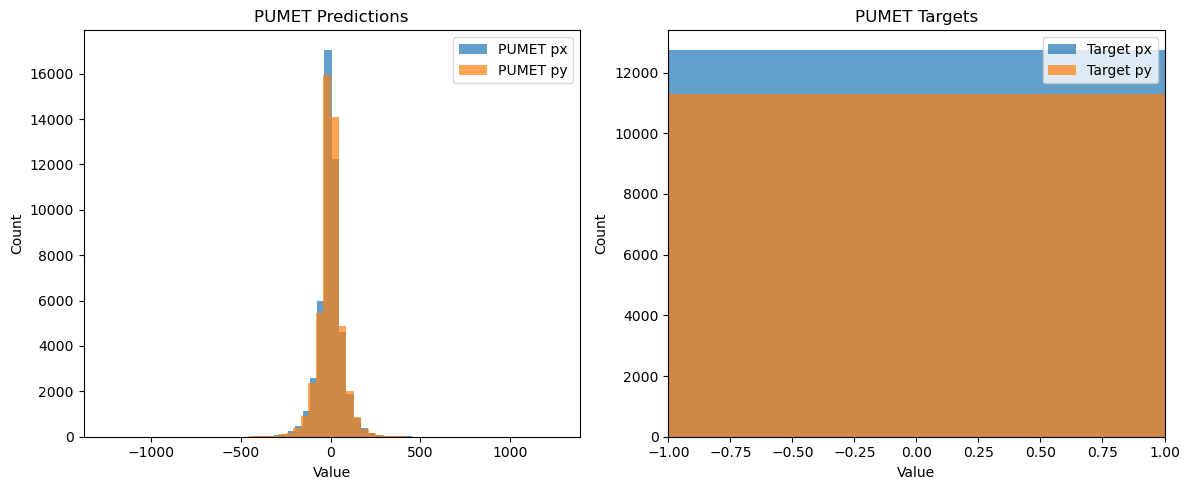

In [28]:
import matplotlib.pyplot as plt

# Plot histogram for predictions (MLMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(predictions[:, 0], bins=50, alpha=0.7, label="MLMET px")
plt.hist(predictions[:, 1], bins=50, alpha=0.7, label="MLMET py")
plt.title("MLMET Predictions")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()

# Plot histogram for Y (MLMET target array)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=50, alpha=0.7, label="Target px")
plt.hist(Y[:, 1], bins=50, alpha=0.7, label="Target py")
plt.title("MLMET Targets")
plt.xlabel("Value")
plt.xlim(-1, 1)
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram for puppi_met_pred (PUMET feature array)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(puppi_met_components[:, 0], bins=50, alpha=0.7, label="PUMET px")
plt.hist(puppi_met_components[:, 1], bins=50, alpha=0.7, label="PUMET py")
plt.title("PUMET Predictions")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()

# Plot histogram for Y (PUMET target array, same as above)
plt.subplot(1, 2, 2)
plt.hist(Y[:, 0], bins=50, alpha=0.7, label="Target px")
plt.hist(Y[:, 1], bins=50, alpha=0.7, label="Target py")
plt.title("PUMET Targets")
plt.xlabel("Value")
plt.xlim(-1, 1)
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Create a new model with all layers after layer 13 removed

# Get the output of layer 13 (indexing starts from 0)
layer_w_out = model.layers[14].output

# Create a new model from the same inputs to the output of layer 13
model_w = Model(inputs=model.input, outputs=layer_w_out)

# Run inference using the new model
predictions_w = model_w.predict([X0, X1, X2, X3])

1500/1500 [==============================] - 3s 2ms/step


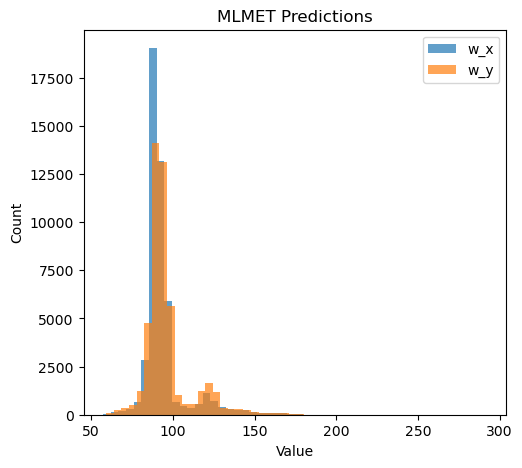

In [30]:
# Plot histogram for MET weights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(predictions_w[:, 0], bins=50, alpha=0.7, label="w_x")
plt.hist(predictions_w[:, 1], bins=50, alpha=0.7, label="w_y")
plt.title("MLMET Predictions")
plt.xlabel("Value")
plt.ylabel("Count")
plt.legend()